In [197]:
import json

from datetime import datetime, timedelta, timezone, time, date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [198]:
'''
This is a proof-of-concept to show how distributions of journey times can be calcuated from stop event data.
'''

'\nThis is a proof-of-concept to show how distributions of journey times can be calcuated from stop event data.\n'

In [199]:
def load_json(filename = 'sample_routes_stops_pst_15s.json'):
    with open(filename, 'r') as f:
        return json.load(f)

In [200]:
df = pd.DataFrame(load_json()).drop(labels = 'index', axis = 'columns')

In [201]:
df.sample(10)

,DID,ROUTE,SID,TIME,VID
6784,14___I_F00,14,7841,1539607746000,7228
16252,1____O_F00,1,3841,1539635476000,5545
13340,1____O_F00,1,6486,1539676470000,5638
10650,1____O_F00,1,6302,1539619750000,5553
21540,1____I_F00,1,3555,1539625287000,5579
5938,14___I_F00,14,5620,1539626308000,7256
12164,1____O_F00,1,6317,1539628408000,5617
20872,1____I_F00,1,4028,1539645514000,5615
8393,14___I_F00,14,5537,1539640592000,7279
9534,14___I_F00,14,5574,1539664165000,7233


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24517 entries, 0 to 9999
Data columns (total 5 columns):
DID      24517 non-null object
ROUTE    24517 non-null object
SID      24517 non-null object
TIME     24517 non-null int64
VID      24517 non-null object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [203]:
#Join data to itself on Direction ID and Vehicle ID
df = df.merge(df, on=['DID', 'ROUTE', 'VID'], suffixes=('_orig', '_dest'))

In [204]:
#Throw out records going backwards in time
df = df[df['TIME_dest'] > df['TIME_orig']]

In [205]:
#Create duration column
df['DUR'] = df['TIME_dest'] - df['TIME_orig']

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3501083 entries, 1 to 7034239
Data columns (total 8 columns):
DID          object
ROUTE        object
SID_orig     object
TIME_orig    int64
VID          object
SID_dest     object
TIME_dest    int64
DUR          int64
dtypes: int64(3), object(5)
memory usage: 240.4+ MB


In [207]:
'''
For each unique (DID, ROUTE, VID, SID_orig, SID_dest, TIME_orig) throw out all records but the shortest duration.
Then do the same for each unique (DID, ROUTE, VID, SID_orig, SID_dest, TIME_dest).
(These records are where the same bus does more than one run on the same line in the same day...
obviously we would get off at the destination stop the first time it came round :-)
If we had Trip ID we would just join on that when merging and this wouldn't be necessary.
'''

"\nFor each unique (DID, ROUTE, VID, SID_orig, SID_dest, TIME_orig) throw out all records but the shortest duration.\nThen do the same for each unique (DID, ROUTE, VID, SID_orig, SID_dest, TIME_dest).\n(These records are where the same bus does more than one run on the same line in the same day...\nobviously we would get off at the destination stop the first time it came round :-)\nIf we had Trip ID we would just join on that when merging and this wouldn't be necessary.\n"

In [208]:
df[(df['DID'] == '14___O_F00') & (df['VID'] == '5422') \
     & (df['SID_orig'] == '5540') & (df['SID_dest'] == '5540')].sort_values('DUR')

,DID,ROUTE,SID_orig,TIME_orig,VID,SID_dest,TIME_dest,DUR
301,14___O_F00,14,5540,1539600049000,5422,5540,1539605331000,5282000
201,14___O_F00,14,5540,1539591346000,5422,5540,1539600049000,8703000
202,14___O_F00,14,5540,1539591346000,5422,5540,1539605331000,13985000


In [209]:
df['min_by_orig'] = df.groupby(['DID', 'ROUTE', 'VID', 'SID_orig', 'SID_dest', 'TIME_orig'])['DUR'].transform('min')

In [210]:
df['min_by_dest'] = df.groupby(['DID', 'ROUTE', 'VID', 'SID_orig', 'SID_dest', 'TIME_dest'])['DUR'].transform('min')

In [211]:
df = df[(df['DUR'] == df['min_by_orig']) & (df['DUR'] == df['min_by_dest'])]

In [212]:
df.drop(columns=['min_by_orig', 'min_by_dest'], inplace=True)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014152 entries, 1 to 7034239
Data columns (total 8 columns):
DID          1014152 non-null object
ROUTE        1014152 non-null object
SID_orig     1014152 non-null object
TIME_orig    1014152 non-null int64
VID          1014152 non-null object
SID_dest     1014152 non-null object
TIME_dest    1014152 non-null int64
DUR          1014152 non-null int64
dtypes: int64(3), object(5)
memory usage: 69.6+ MB


/Users/jonathanbate/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

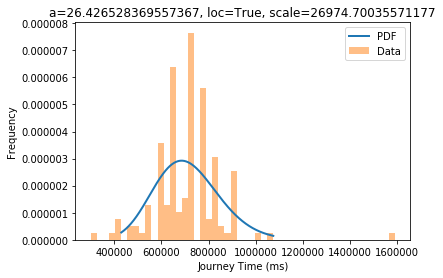

In [214]:
#Now we have all the trip durations! EXCITING.
#Let's pick a random stop pair and see what it looks like
df_sample = df.sample(1)
data = df.merge(df_sample, on=['DID', 'ROUTE', 'SID_orig', 'SID_dest'], suffixes=['', '_sample'])['DUR']

dist = st.gamma

# fit dist to data
params = dist.fit(data, floc=True)

y, x = np.histogram(data)
x = (x + np.roll(x, -1))[:-1] / 2.0

# Separate parts of parameters
arg = params[:-2]
loc = params[-2]
scale = params[-1]

# Get sane start and end points of distribution
start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

# Build PDF and turn into pandas Series
x = np.linspace(start, end, 10000)
y = dist.pdf(x, loc=loc, scale=scale, *arg)
pdf = pd.Series(y, x)

# Display
plt.figure()
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)


ax.set_title(u'a={}, loc={}, scale={}'.format(arg[0], loc, scale))
ax.set_xlabel(u'Journey Time (ms)')
ax.set_ylabel('Frequency')


In [215]:
class CalcDistribution:
    def __init__(self, n):
        self.n = n
        self.i = 0

    def __call__(self, x):
        self.i += 1

        if self.i%1000==0:
            print( "%s/%s"%(self.i, self.n) )

        try:
            params = st.gamma.fit(x[x > 0], floc=0)
            shape = params[0]
            scale = params[2]
        except Exception as e:
            print(e)
            print(x)
            shape = np.NaN
            scale = np.NaN
        return shape, scale

In [216]:
n_orig = df['SID_orig'].unique().size
n_dest = df['SID_dest'].unique().size
n_groups = n_orig*n_dest
calc_distribution = CalcDistribution(n_groups)

print( f"Fitting distribution to {n_groups}ish groups" )

Fitting distribution to 35344ish groups


In [217]:
#Calculate journey time distribution for each stop pair
dists = df.groupby(['DID', 'ROUTE', 'SID_orig', 'SID_dest'])['DUR'].agg([calc_distribution, "size"]).reset_index()

1000/35344
2000/35344
3000/35344
4000/35344
5000/35344
6000/35344
7000/35344
8000/35344


In [218]:
#Split into columns
dists[['shape', 'scale']] = dists['CalcDistribution'].apply(pd.Series)
dists = dists.drop('CalcDistribution', axis=1)

#Drop NAs
dists = dists.dropna()

#Generate Target
dists['mean'] = dists['shape'] * dists['scale']

In [220]:
dists

,DID,ROUTE,SID_orig,SID_dest,size,shape,scale,mean
0,14___I_F00,14,36498,36498,77,8.594235,1.203688e+06,1.034478e+07
1,14___I_F00,14,36498,5336,77,3.098071,3.184931e+06,9.867143e+06
2,14___I_F00,14,36498,5530,78,5.529156,1.767602e+06,9.773346e+06
3,14___I_F00,14,36498,5531,78,5.493460,1.766588e+06,9.704679e+06
4,14___I_F00,14,36498,5533,77,7.844788,1.240777e+06,9.733636e+06
5,14___I_F00,14,36498,5535,77,7.720069,1.249466e+06,9.645961e+06
6,14___I_F00,14,36498,5537,77,7.648936,1.252039e+06,9.576766e+06
7,14___I_F00,14,36498,5541,78,7.831274,1.190066e+06,9.319731e+06
8,14___I_F00,14,36498,5542,78,7.727894,1.196302e+06,9.244897e+06
9,14___I_F00,14,36498,5544,79,7.504965,1.207838e+06,9.064785e+06
